In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt, floor
from heapq import heappop, heappush
from datetime import datetime
import seaborn as sns
import pandas as pd

from theta.src.grid import Map

%matplotlib inline

In [2]:
class TestCase:
    def __init__(self, difficulty, start, goal, optimal):
        self.difficulty = difficulty
        self.start = start
        self.goal = goal
        self.optimal = optimal

In [3]:
def read_map_from_file(path):
    with open(path, "r") as f:
        map_type = f.readline()
        height = f.readline().split()[1]
        width = f.readline().split()[1]
        f.readline()
        # now we read the map
        map_canvas = "\n".join(f.readlines())
        return map_canvas, int(width), int(height)

In [4]:
def read_scenes_from_file(path):
    tests = []
    with open(path, "r") as f:
        version = f.readline()
        for data in f.readlines():
            difficulty, _,_,_, start_y, start_x, goal_y, goal_x, optimal = data.split()
            test = TestCase(int(difficulty), (int(start_x), int(start_y)), (int(goal_x), int(goal_y)), float(optimal))
            tests.append(test)
    return tests

In [5]:
class TestSet:
    def __init__(self, name, path, output):
        self.map = Map()
        self.tests = []
        self.max_diff = 0
        self.name = name
        
        self.read_from_file(path)
        self.input_path = path
        self.output_path = output
    
    def read_from_file(self, path):
        map_data = read_map_from_file(path + ".map")
        self.map.read_from_string(*map_data)
        self.tests = read_scenes_from_file(path + ".map.scen")
        self.max_diff = max([item.difficulty for item in self.tests])
        
    def choose_tests(self, number):
        tests = []
        i = 0
        for diff in range(number):
            target = diff * self.max_diff  // number
            while self.tests[i].difficulty != target:
                i += 1
            tests.append(self.tests[i])
            i += 1
        return tests

In [6]:
sets = []
setSC = TestSet("starcraft", "analysis/data/starcraft/NovaStation", "analysis/results/starcraft/theta/NovaStation")
sets.append(setSC)
setCity = TestSet("paris", "analysis/data/paris/Paris_1_256", "analysis/results/paris/theta/Paris_1_256")
sets.append(setCity)
setMaze = TestSet("maze", "analysis/data/maze/maze512-32-7", "analysis/results/maze/theta/maze512-32-7")
sets.append(setMaze)
setRand = TestSet("random", "analysis/data/random/random512-10-5", "analysis/results/random/theta/random512-10-5")
sets.append(setRand)
setRoom = TestSet("room", "analysis/data/room/16room_005", "analysis/results/room/theta/16room_005")
sets.append(setRoom)

In [7]:
names_theta = [".theta.euclidian.w=1_p=1_k=8", ".theta_ap.euclidian", ".theta_ap.weighted"]
labels_theta = ["basic theta", "AP theta", "AP theta (wh)"]

In [8]:
def load_data(names, labels):
    data_out = []
    for testSet in sets:
        main_table = pd.DataFrame()
        table_list = []
        for i in range(len(names)):
            table = pd.read_csv(testSet.output_path + names[i] + ".stat")
            table.insert(0, "name", labels[i])
            table_list.append(table)

        for i in range(len(names_theta)):
            table_list[i]["normed_expansions"] = table_list[i]["expansions"] / table_list[0]["expansions"]
            table_list[i]["normed_tree_size"] = table_list[i]["max_tree_size"] / table_list[0]["max_tree_size"]
            table_list[i]["normed_runtime"] = table_list[i]["runtime"] / table_list[0]["runtime"]
            main_table = pd.concat([main_table, table_list[i]], ignore_index = True)
        data_out.append(main_table)
    return data_out

In [9]:
data_theta = load_data(names_theta, labels_theta)

In [10]:
data_theta[0]

,name,difficulty,expansions,runtime,way_length,suboptimal,max_tree_size,normed_expansions,normed_tree_size,normed_runtime
0,basic theta,0,2,0.000255,2.236068,0.926210,28,1.000000,1.000000,1.000000
1,basic theta,2,9,0.000950,9.486833,0.926210,78,1.000000,1.000000,1.000000
2,basic theta,5,23,0.003758,19.924859,0.927372,158,1.000000,1.000000,1.000000
3,basic theta,8,38,0.004356,30.695188,0.926168,243,1.000000,1.000000,1.000000
4,basic theta,11,148,0.014451,44.124965,0.972242,487,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
295,AP theta (wh),262,76286,9.945382,989.117347,0.942697,80094,1.246992,0.649270,0.407473
296,AP theta (wh),264,88756,11.733199,993.454654,0.939972,90363,1.019996,0.517182,0.326753
297,AP theta (wh),267,90064,11.861963,1005.700103,0.939382,91430,1.018363,0.514835,0.333769
298,AP theta (wh),270,89586,11.775634,1015.790931,0.940388,91023,1.017133,0.514789,0.331512


In [11]:
def smooth_data(stat_type, in_data, labels):
    
    result_data = []

    for n in range(len(sets)):
        max_diff = max(in_data[n]["difficulty"]) 
        c = max_diff // 6 # smooth const
        difficulty = [i + c for i in range(max_diff - 2 * c + 1)]
        main_table = pd.DataFrame()
        for i in range(len(labels)):
            table = pd.DataFrame()
            sum_time = [0] * (max_diff - 2 * c + 1)
            cnt_time = [0] * (max_diff - 2 * c + 1)

            for j in range(len(in_data[n].index)):
                if in_data[n]["name"][j] == labels[i]:
                    diff = in_data[n]["difficulty"][j]
                    runtime = in_data[n][stat_type][j]
                    for k in range(max(0, diff - 2 * c), min(max_diff - 2 * c, diff) + 1):
                        sum_time[k] += runtime
                        cnt_time[k] += 1



            table["difficulty"] = difficulty
            table["sum_time"] = sum_time
            table["cnt"] = cnt_time
            table[stat_type] = table["sum_time"] / table["cnt"]
            table.pop("sum_time")
            table.pop("cnt")
            table.insert(0, "name", str(labels[i]))

            main_table = pd.concat([main_table, table], ignore_index = True)
        result_data.append(main_table)
    return result_data

In [12]:
runtime_data = smooth_data("runtime", data_theta, labels_theta)

In [13]:
runtime_data[0]

,name,difficulty,runtime
0,basic theta,45,1.113523
1,basic theta,46,1.200021
2,basic theta,47,1.200021
3,basic theta,48,1.300035
4,basic theta,49,1.300035
...,...,...,...
547,AP theta (wh),224,8.375044
548,AP theta (wh),225,8.603510
549,AP theta (wh),226,8.603510
550,AP theta (wh),227,8.603510


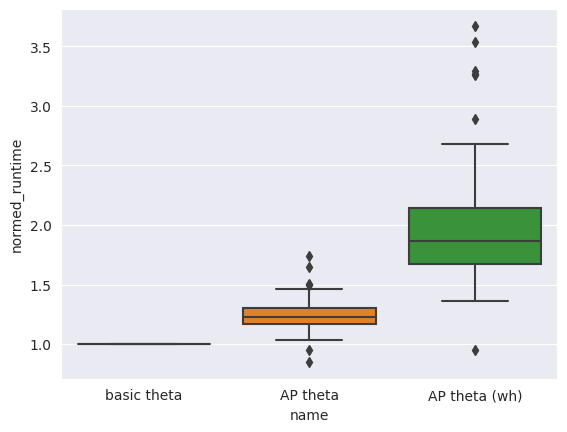

In [14]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.boxplot(data=data_theta[4], x="name", y="normed_runtime")

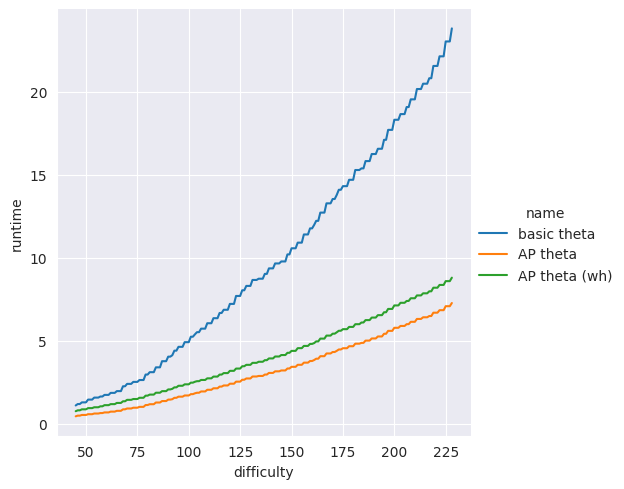

In [15]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data[0], x="difficulty", y="runtime", hue = "name", kind="line")

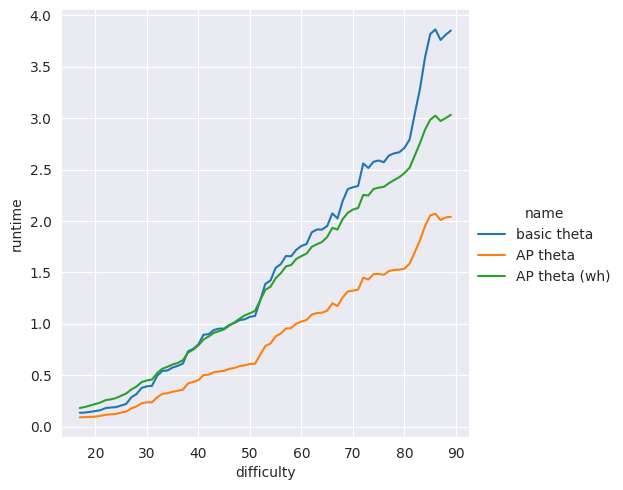

In [16]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data[1], x="difficulty", y="runtime", hue = "name", kind="line")

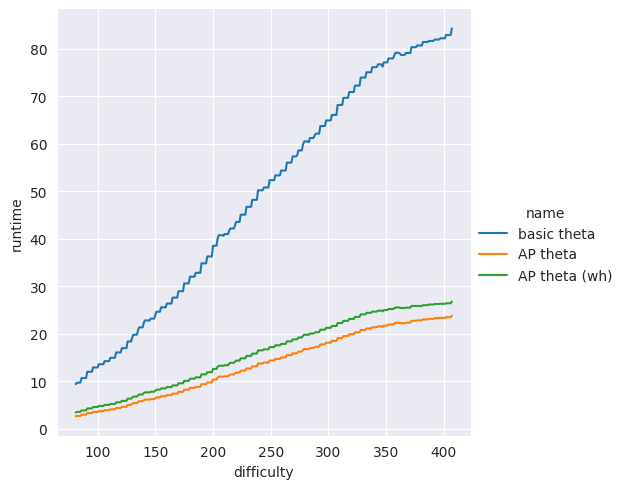

In [17]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data[2], x="difficulty", y="runtime", hue = "name", kind="line")

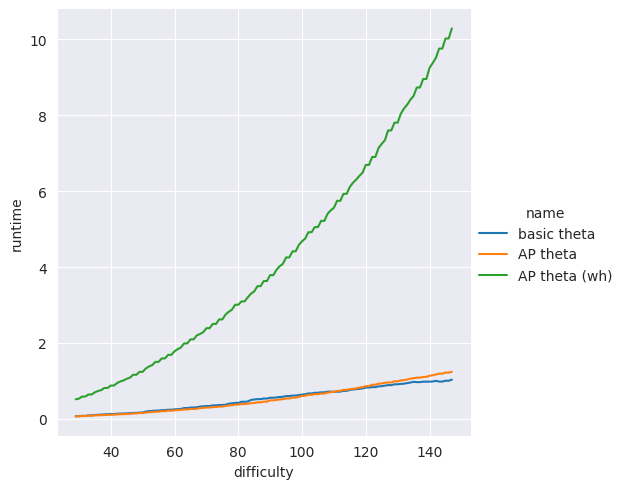

In [18]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data[3], x="difficulty", y="runtime", hue = "name", kind="line")

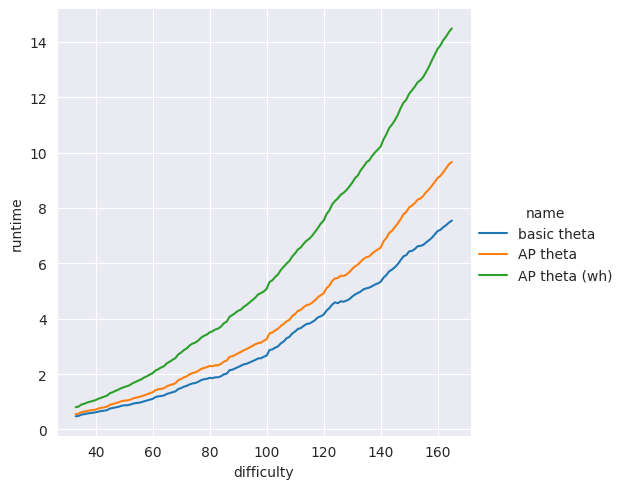

In [19]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("darkgrid"):
    sns.relplot(data=runtime_data[4], x="difficulty", y="runtime", hue = "name", kind="line")